# Introduction EDP - TP2 - Equations de transport et formulation faible

In [61]:
import numpy as np
import numpy.linalg as npl
import numpy.fft as fft
import scipy as sp
import scipy.linalg as spl
import scipy.sparse as sps
from scipy.sparse import diags
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib inline

In [61]:
pi = np.pi

## I - Equations de transport

$$u^{n+1}_{j} = u^{n-1}_j + c \frac{\partial t}{\partial x} (u^n_{j+1} - u^n_{j-1})$$

### 1. Schéma de Saute-Mouton : stabilité, instabilité 

In [62]:
def u0(x, mu=0, sigma2=1):
    exp = np.exp(-0.5 * ((x-mu)**2)/sigma2)
    return exp/np.sqrt(2*pi*sigma2)

In [63]:
def v0(x, k=0.5, mu=0, sigma2=1):
    return u0(x, mu, sigma2) * np.sin(2*k*pi*x)

In [64]:
def w0(x, a=-2.5, b=2.5):
    return np.where((x>=a) & (x<=b), 1, 0) 

In [65]:
def sauteMouton(u0,u1,c,dt,dx,T):
    U = [u0,u1]
    
    A = diags([-1,0,1], [-1,0,1], shape=( len(u0) , len(u0) )).toarray()
    A[0,len(u0)-1] = -1
    A[len(u0)-1,0] = 1
    
    U0 = np.copy(u0)
    U1 = np.copy(u1)
    for i in range( int(T/dt) - 1 ):
        U2 = U0 - (c*dt/dx)*A.dot(U1)
        U.append(U2)
        U0 = np.copy(U1)
        U1 = np.copy(U2)
    return U

In [66]:
def testMouton(c,dt,dx,T):
    x = np.linspace(-10,10,1000)
    U0 = u0(x)
    
    mat_p = diags([-1,0,1], [-1,0,1], shape=( len(U0) , len(U0) )).toarray()
    mat_p[0,len(U0)-1] = -1
    mat_p[len(U0)-1,0] = 1
    
    mat_p2 = diags([1,-2,1], [-1,0,1], shape=( len(U0) , len(U0) )).toarray()
    mat_p2[0,len(U0)-1] = 1
    mat_p2[len(U0)-1,0] = 1
    
    U1 = U0 - (c*dt/dx)*mat_p.dot(U0) +(c/2)*(dt**2/dx**2)*mat_p2.dot(U0)
    U = sauteMouton(U0,U1,c,dt,dx,T)
    plt.plot(x,U[0],x,U[-1])
    plt.show()

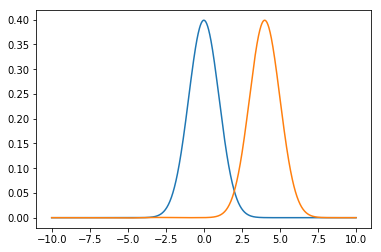

In [67]:
testMouton(1,(1/300)*0.2,1/300,4)

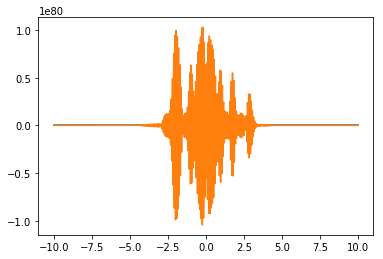

In [80]:
testMouton(1,(1/3)*0.2,1/300,4)

### 2. Schéma décentré-amont : stabilité, instabilité 

In [68]:
def sch_décentré_amont(U0, c, dt, dx, T):
    U = [U0]
    N = U0.size
    A = np.eye(N) - c*dt/(dx) * sps.diags([-1, 1, -1], [-1, 0, N-1], shape=[N, N]).toarray()
    
    n = 1
    
    while n*dt <= T:
        U1 = A.dot(U[-1])
        U.append(U1)
        n += 1
        
    return U

In [69]:
def test_sch_décentré_amont(min, max, c, dt=0.005, dx=0.01, T=0.5):
    x = np.linspace(min, max, int((max-min)/dx))
    for func in [u0, v0, w0]:
        U = sch_décentré_amont(func(x), c, dt, dx, T)
        plt.figure(clear=True)
        plt.plot(x ,U[0])
        plt.plot(x, U[-1])
        plt.show()

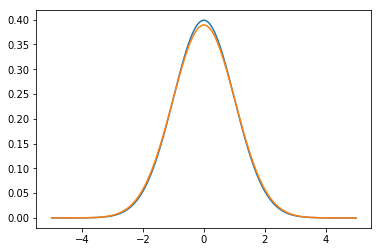

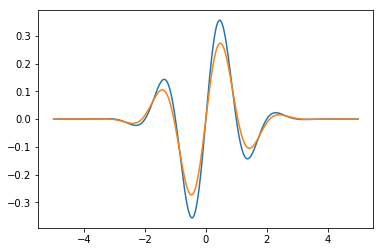

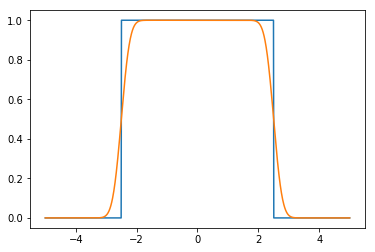

In [74]:
test_sch_décentré_amont(-5, 5, c=0.5, dt=0.01, dx=0.01, T=20)

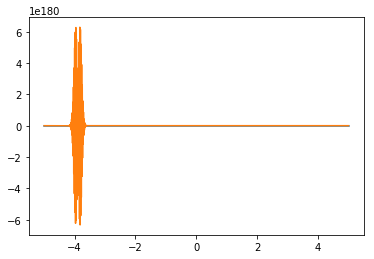

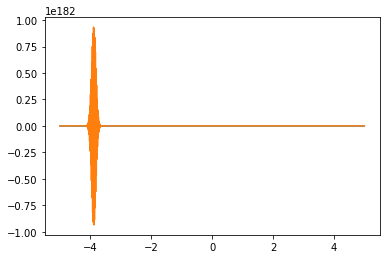

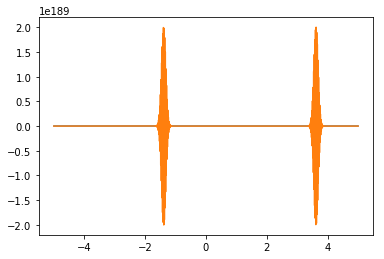

In [75]:
test_sch_décentré_amont(-5, 5, c=0.5, dt=0.1, dx=0.01, T=20)

### 3. Réécriture du schéma décentré-amont

In [71]:
def sch_décentré(U0, c, dt, dx, T):
    U = [U0]
    N = U0.size
    A = np.eye(N) + c*dt/dx * sps.diags([-0.5, 1.5, -1, -0.5, 1.5], [-N+1, -1, 0, 1, N-1], shape=[N, N]).toarray()
    
    n = 1
    
    while n*dt <= T:
        U1 = A.dot(U[-1])
        U.append(U1)
        n += 1
        
    return U

In [72]:
def test_sch_décentré(min, max, c, dt=0.005, dx=0.01, T=0.5):
    x = np.linspace(min, max, int((max-min)/dx))
    for func in [u0, v0, w0]:
        U = sch_décentré(func(x), c, dt, dx, T)
        plt.figure(clear=True)
        plt.plot(x ,U[0])
        plt.plot(x, U[-1])
        plt.show()

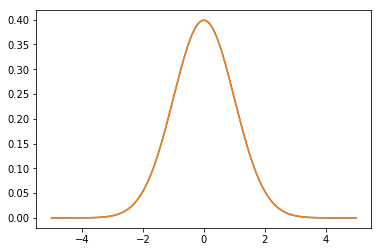

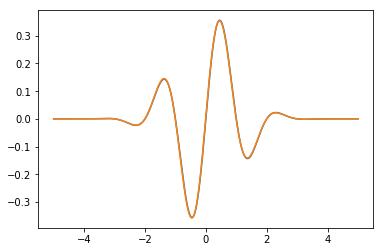

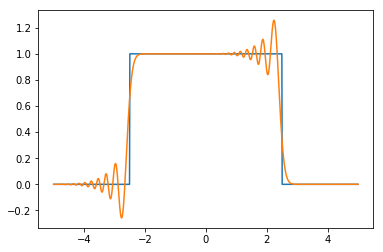

In [73]:
test_sch_décentré(-5, 5, c=0.5, dt=0.005, dx=0.01, T=40)

In [19]:
plt.close('all')

## II - Visualiser des fonctions d'un espace de Sobolev

On travaille avec les espaces suivants :

$$L^2\left(\left[0, 2\pi\right]^d\right) = \left\{ f, \int_{0}^{2\pi} \left|f(x)\right|^2 dx < +\infty \right\}$$ 

$$H^{m}_{per}\left(\left[0, 2\pi\right]\right) = 
\left\{ 
f \in L^2\left(\left[0, 2\pi\right]\right), \sum_{k \in \mathbb{z}} \left(1 + k^{2}\right)^m \left|c_{k}(f)\right|^2 < +\infty 
\right\}$$

$$H^{m}_{per}\left(\left[0, 2\pi\right]^2\right) = 
\left\{ 
f \in L^2\left(\left[0, 2\pi\right]^2\right), \sum_{k, l \in \mathbb{z}} \left(1 + k^{2} + l^{2}\right)^m \left|c_{k,l}(f)\right|^2 < +\infty 
\right\}$$

On veut constuire des fonctions $f_{i}$ dont les coefficients de Fourier vérifient :
$$\left|c_{k}\left(f_{i}\right)\right| = \left(1 + k^{2}\right)^{-\alpha/2} \text{ en dimension 1}$$
$$\left|c_{k, l}\left(f_{i}\right)\right| = \left(1 + k^{2} + l^{2}\right)^{-\alpha/2} \text{ en dimension 2}$$

En cherchant $f_{2}$ telle que $f_{2} \in H^{1}([0, 2\pi]^{d}) \text{ et} \notin H^{2}([0, 2\pi]^{d})$, on obtient :

$$
\sum_{k \in \mathbb{z}} \left(1 + k^{2}\right)^m \left|c_{k}(f)\right|^2 < +\infty 

\sum_{k, l \in \mathbb{z}} \left(1 + k^{2} + l^{2}\right)^m \left|c_{k,l}(f)\right|^2 < +\infty 

$$

In [41]:
def sobolev(alpha=1, N=2**9, pha=None):
    K, L = np.meshgrid(np.arange(N), np.arange(N))
    module = (1 + K**2 + L**2)**(-alpha/2)
    
    if pha is None:
        phase = np.random.random((N, N))*2*pi
        coeffs = module * np.exp(1j * phase)
    
    coeffs = module * np.exp(1j * pha)
    f = fft.ifft2(coeffs)
    
    return np.real(f)

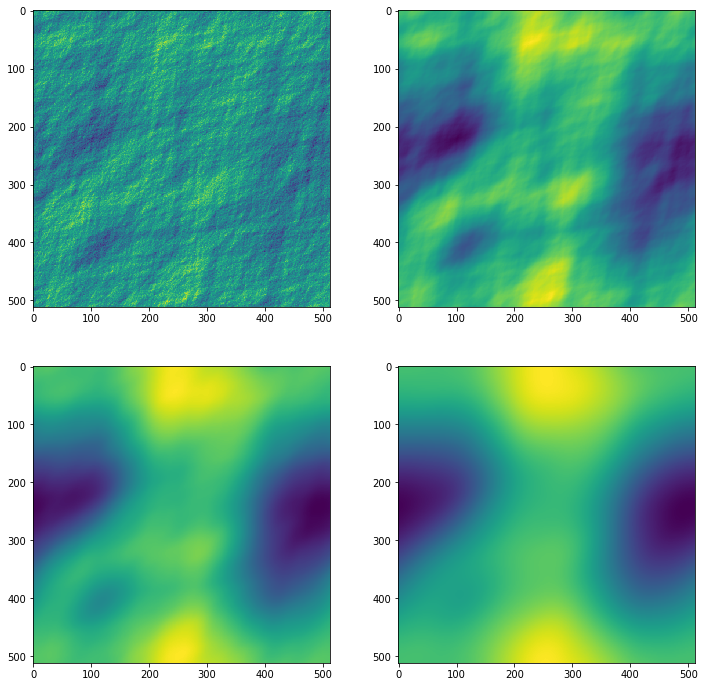

In [42]:
fig = plt.figure(figsize=(12, 12))
N = 2**9
seed = np.random.randint(10000)
np.random.seed()
phase = np.random.random((N, N))*2*pi
for i in range(1, 5):
    
    ax = fig.add_subplot(220+i)
    image = sobolev(i, N, phase)
    ax.imshow(image)

plt.show()

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

phase = np.random.random((N, N))*2*pi
X, Y = np.meshgrid(np.arange(N), np.arange(N))

image = sobolev(10, N, phase)
    
ax.plot_surface(X, Y, image, cmap="Purples")
plt.show()

FigureCanvasNbAgg()

In [46]:
images = []

seed = np.random.randint(10000)
np.random.seed()
phase = np.random.random((N, N))*2*pi
for i in np.linspace(1, 5, num=50):
    image = sobolev(i, N, phase)
    images.append(image)

In [47]:
len(images)
plt.figure()
plt.imshow(images[0])
plt.show()

FigureCanvasNbAgg()

In [48]:
def plot_sobolev(alpha=1, seed=100):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    N = 2**7
    np.random.seed(seed)
    phase = np.random.random((N, N))*2*pi

    image = sobolev(alpha, N, phase)
    
    ax.imshow(image)
    plt.show()

In [49]:
plt.close('all')

## Exercice 3